In [1]:
import os
import cv2
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.model import ShipDetector
from src.utils import rle_decode, rle_encode
from src.evaluation import compute_f2_score

# Configuration

In [2]:
# Settings
SAMPLE_IMAGE_SHOW_COUNT = 8  # number of sample images to visualize
MODEL_CHOICE = "yolo11n-seg.pt"  # yolo11n-seg.pt, yolo11s-seg.pt, yolo11m-seg.pt, yolo11l-seg.pt, yolo11x-seg.pt

# Path definitions
ROOT_PATH = os.path.abspath(".")
TEST_IMAGES_PATH = os.path.join(ROOT_PATH, "data/test_v2") # NOTE: I've used a subset of the train images for demo purposes
TEST_LABELS_CSV = os.path.join(ROOT_PATH, "data/test_ship_segmentations_v2.csv") # NOTE: I've used a subset of the train images for demo purposes
MODELS_PATH = os.path.join(ROOT_PATH, "models")
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_CHOICE)    # Will be automatically downloaded if not present
OUTPUT_PATH = os.path.join(ROOT_PATH, "outputs")

# Create necessary directories
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

# Read and visualize data

ImageId: 000155de5.jpg, EncodedPixels: 264661 17 265429 33 266197 33 ...
/Users/paulvanhoutum/Documents/Coding/dsc_defensie_assessment_TEST/dsc-defensie-assessment_ship-detection-api/data/test_v2/000155de5.jpg
ImageId: 000194a2d.jpg, EncodedPixels: 360486 1 361252 4 362019 5 362...
/Users/paulvanhoutum/Documents/Coding/dsc_defensie_assessment_TEST/dsc-defensie-assessment_ship-detection-api/data/test_v2/000194a2d.jpg
ImageId: 000194a2d.jpg, EncodedPixels: 51834 9 52602 9 53370 9 54138 ...
/Users/paulvanhoutum/Documents/Coding/dsc_defensie_assessment_TEST/dsc-defensie-assessment_ship-detection-api/data/test_v2/000194a2d.jpg
ImageId: 000194a2d.jpg, EncodedPixels: 198320 10 199088 10 199856 10 ...
/Users/paulvanhoutum/Documents/Coding/dsc_defensie_assessment_TEST/dsc-defensie-assessment_ship-detection-api/data/test_v2/000194a2d.jpg
ImageId: 000194a2d.jpg, EncodedPixels: 55683 1 56451 1 57219 1 57987 ...
/Users/paulvanhoutum/Documents/Coding/dsc_defensie_assessment_TEST/dsc-defensie-assessm

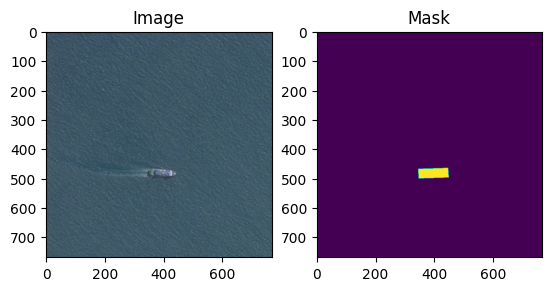

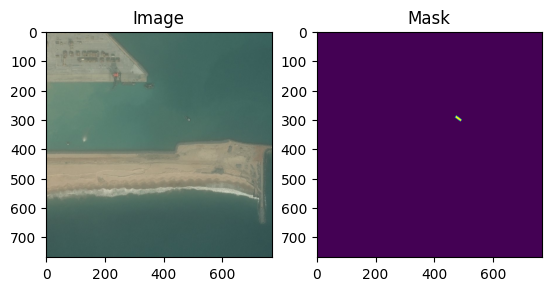

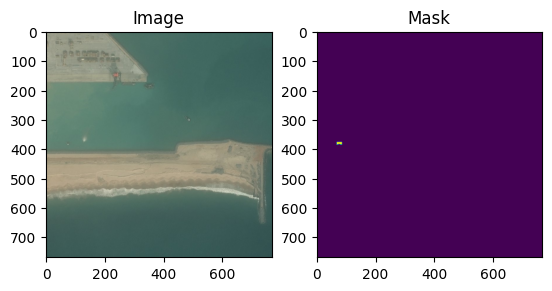

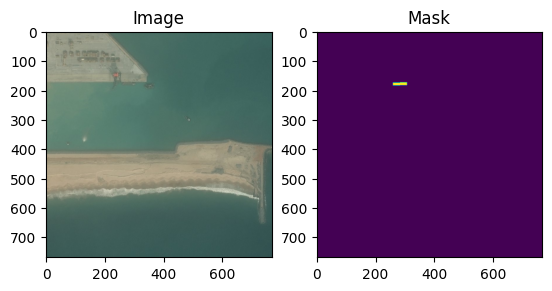

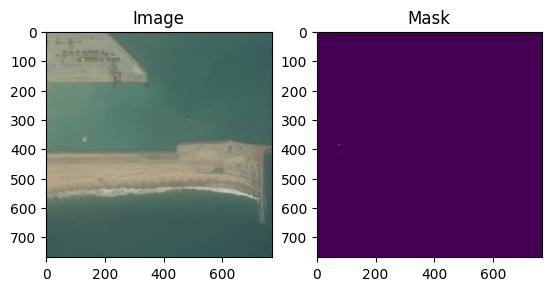

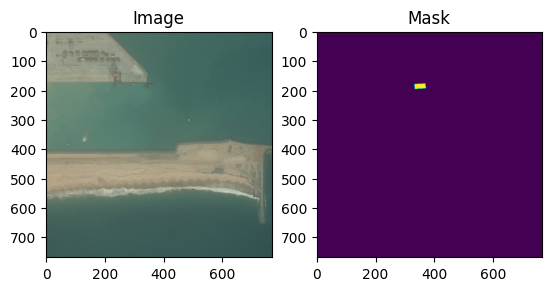

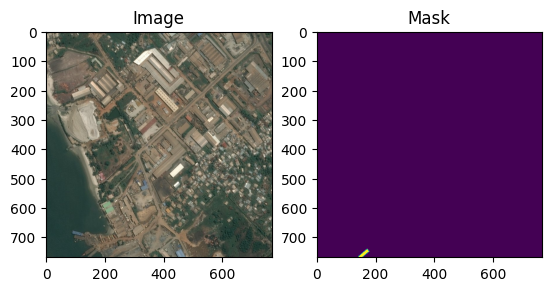

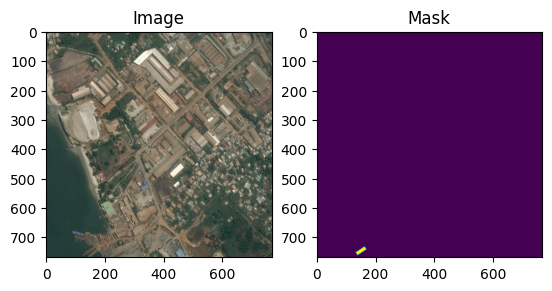

In [3]:
# Read labels
df_test_labels = pd.read_csv(TEST_LABELS_CSV)

# Extract sample images that has a mask
sample_rows = df_test_labels[df_test_labels['EncodedPixels'].notna()].iloc[0:SAMPLE_IMAGE_SHOW_COUNT]  
for index, sample_row in sample_rows.iterrows():
    print(f"ImageId: {sample_row['ImageId']}, EncodedPixels: {sample_row['EncodedPixels'][:30]}...")
    image_path = os.path.join(TEST_IMAGES_PATH, sample_row['ImageId'])
    print(image_path)
    image = cv2.imread(image_path)[..., ::-1]

    # Extract mask definition and decode
    mask = rle_decode(sample_row['EncodedPixels'], image.shape[:2])

    # Display image and mask
    plt.figure()
    plt.subplot(1,2,1); plt.imshow(image); plt.title('Image')
    plt.subplot(1,2,2); plt.imshow(mask); plt.title('Mask')

# Model inference on examples

In [4]:
# Initialize once
detector = ShipDetector(MODEL_PATH, conf_threshold=0.1)

# Get list of all some image paths to visualize
image_files = os.listdir(TEST_IMAGES_PATH)[:SAMPLE_IMAGE_SHOW_COUNT]
for i, image_file in enumerate(image_files):
    
    print(f"Processing {i+1}/{len(image_files)} {image_file}")
    
    # Get image name and full path
    image_name, _ = os.path.splitext(image_file)
    image_path = os.path.join(TEST_IMAGES_PATH, image_file)

    # Read image
    image = cv2.imread(image_path)[..., ::-1]
    
    # Get binary mask and contours
    mask = detector.predict_mask(image)
    contoured = detector.predict_contours(image)
    
    # Save image and mask
    cv2.imwrite(os.path.join(OUTPUT_PATH, f"{image_name}_predicted_mask.png"), mask)
    cv2.imwrite(os.path.join(OUTPUT_PATH, f"{image_name}_predicted_contours.png"), contoured[..., ::-1])
    print(f"Saved {image_name}_predicted_mask.png and {image_name}_predicted_contours.png to {OUTPUT_PATH}")


Processing 1/8 000155de5.jpg
Saved 000155de5_predicted_mask.png and 000155de5_predicted_contours.png to /Users/paulvanhoutum/Documents/Coding/dsc_defensie_assessment_TEST/dsc-defensie-assessment_ship-detection-api/outputs
Processing 2/8 00003e153.jpg
Saved 00003e153_predicted_mask.png and 00003e153_predicted_contours.png to /Users/paulvanhoutum/Documents/Coding/dsc_defensie_assessment_TEST/dsc-defensie-assessment_ship-detection-api/outputs
Processing 3/8 000592296.jpg
Saved 000592296_predicted_mask.png and 000592296_predicted_contours.png to /Users/paulvanhoutum/Documents/Coding/dsc_defensie_assessment_TEST/dsc-defensie-assessment_ship-detection-api/outputs
Processing 4/8 0005d6d95.jpg
Saved 0005d6d95_predicted_mask.png and 0005d6d95_predicted_contours.png to /Users/paulvanhoutum/Documents/Coding/dsc_defensie_assessment_TEST/dsc-defensie-assessment_ship-detection-api/outputs
Processing 5/8 000194a2d.jpg
Saved 000194a2d_predicted_mask.png and 000194a2d_predicted_contours.png to /Users/p

# Model evaluation

In [5]:
all_gt_masks = []
all_pred_masks = []

# Iterate over each image in the test set
for image_id, group in tqdm.tqdm(df_test_labels.groupby("ImageId")):
    gt_masks = []
    
    # Read image to get shape
    image_path = os.path.join(TEST_IMAGES_PATH, image_id)
    image = cv2.imread(image_path)[..., ::-1]

    # Get (decoded) ground truth masks for this image
    for encoded_pixels in group["EncodedPixels"].dropna():
        gt_mask = rle_decode(encoded_pixels, image.shape[:2])
        gt_masks.append(gt_mask)
                
    # Get predicted masks for this image
    pred_masks = detector.predict_instance_masks(image)
    
    # Save both ground truth and predicted masks for this image
    all_gt_masks.append(gt_masks)
    all_pred_masks.append(pred_masks)

# Evaluate using F2 Score
f2_score = compute_f2_score(all_pred_masks, all_gt_masks, iou_thresholds=np.arange(0.5, 1.0, 0.05))
print(f"F2 Score: {f2_score:.4f}")

100%|██████████| 18/18 [00:01<00:00,  9.69it/s]


F2 Score: 0.1250
